<a href="https://colab.research.google.com/github/brandontan99/Self_Love_App/blob/master/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
!git clone https://github.com/brandontan99/Self_Love_App.git
%cd /content/Self_Love_App
!pip install scikit-multilearn

from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import f1_score
from skmultilearn.adapt import *
from skmultilearn.problem_transform import *
from skmultilearn.ensemble import * 
from skmultilearn.cluster import *
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
import pandas as pd
from data_cleaning import data_cleaning
from Data_Normalization import data_encoding, data_normalization
from scipy import sparse
import time

# random seed
seed = 0

fatal: destination path 'Self_Love_App' already exists and is not an empty directory.
/content/Self_Love_App


# Data Preparation

In [2]:
df = pd.read_csv("WID3006 ML Questionnaire.csv")
df = data_cleaning(df)
df = data_encoding(df)
df_norm = data_normalization(df)
df_norm

,Gender: _Female,Gender: _Male,What is your current occupation?_Employed,What is your current occupation?_Retired,What is your current occupation?_Unemployed,What is your current occupation?_University student,What boosts your confidence ? _By earning a lot of money,What boosts your confidence ? _By leading others to success,What boosts your confidence ? _Get the most/ special attention among the members,What boosts your confidence ? _Owning famous brands,What boosts your confidence ? _When someone acknowledges you,What boosts your confidence ? _When you accomplish a project,I prefer to spend my money on...._Activities with friends,I prefer to spend my money on...._Food,I prefer to spend my money on...._Home Improvements,I prefer to spend my money on...._The latest fashion,I prefer to spend my money on...._The latest technology,How do you organize your thoughts? Please pick whichever is closest._Any combination of these,How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph,How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud,How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar,How do you organize your thoughts? Please pick whichever is closest._Jotting it down on a scrap of paper,Choose a pet which you prefer to keep._Bird,Choose a pet which you prefer to keep._Cat,Choose a pet which you prefer to keep._Dog,Choose a pet which you prefer to keep._Fish,Choose a pet which you prefer to keep._Hamster,Choose a pet which you prefer to keep._Horse,Choose a pet which you prefer to keep._I'm not a pet person,Choose a pet which you prefer to keep._Rabbit,Choose a pet which you prefer to keep._Snake,Choose a pet which you prefer to keep._Tortoise,What is your favorite time of the day?_Afternoon,What is your favorite time of the day?_Evening,What is your favorite time of the day?_Morning,What is your favorite time of the day?_Night,Would you rather visit the future or the past?_Neither. I prefer the present,Would you rather visit the future or the past?_The future,Would you rather visit the future or the past?_The past,What do you worry more about the most?_How others see me,...,What is your learning style? (Pick one that benefit you the most)_By attending online courses,What is your learning style? (Pick one that benefit you the most)_By doing assignments,What is your learning style? (Pick one that benefit you the most)_By doing tutorial/lab questions,What is your learning style? (Pick one that benefit you the most)_By reading a physical book,What is your learning style? (Pick one that benefit you the most)_By reading an e-Book,Do you enjoy socializing with large groups of people?,Do you enjoy challenges?,How creative of a person do you think you are?,How logical of a person do you think you are?,Would you prefer to engage your brain more than your body?,Are you a curious person?,Are you a perfectionist?,Are you a trusting person?,Do you have lot of patience?,Do you organize your schedule well?,Do you like to sit in front of a computer for long hours?,Do you enjoy making others happy?,Can you understand others' perspectives and feelings?,Team sports,Badminton,Dancing,Fishing,Playing computer games,Playing board games,Reading,Exercising,Writing,Gardening,Painting,Cooking,Singing,Puzzles,Collecting,Watching movies,Watching TV series,Sleeping,Photography and Videography,Listening to music,Crocheting,Playing a musical instrument
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.50,0.50,0.50,0.50,0.50,0.666667,1.00,0.75,0.75,0.75,0.75,0.75,0.75,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0

In [3]:
for i, name in enumerate(df_norm.columns):
  print(i, name)

0 Gender: _Female
1 Gender: _Male
2 What is your current occupation?_Employed
3 What is your current occupation?_Retired
4 What is your current occupation?_Unemployed
5 What is your current occupation?_University student
6 What boosts your confidence ? _By earning a lot of money
7 What boosts your confidence ? _By leading others to success
8 What boosts your confidence ? _Get the most/ special attention among the members
9 What boosts your confidence ? _Owning famous brands
10 What boosts your confidence ? _When someone acknowledges you
11 What boosts your confidence ? _When you accomplish a project
12 I prefer to spend my money on...._Activities with friends
13 I prefer to spend my money on...._Food
14 I prefer to spend my money on...._Home Improvements
15 I prefer to spend my money on...._The latest fashion
16 I prefer to spend my money on...._The latest technology
17 How do you organize your thoughts? Please pick whichever is closest._Any combination of these
18 How do you organize 

In [4]:
x = df_norm.iloc[:, :76]
y = df_norm.iloc[:, 76:]
x.describe()

,Gender: _Female,Gender: _Male,What is your current occupation?_Employed,What is your current occupation?_Retired,What is your current occupation?_Unemployed,What is your current occupation?_University student,What boosts your confidence ? _By earning a lot of money,What boosts your confidence ? _By leading others to success,What boosts your confidence ? _Get the most/ special attention among the members,What boosts your confidence ? _Owning famous brands,What boosts your confidence ? _When someone acknowledges you,What boosts your confidence ? _When you accomplish a project,I prefer to spend my money on...._Activities with friends,I prefer to spend my money on...._Food,I prefer to spend my money on...._Home Improvements,I prefer to spend my money on...._The latest fashion,I prefer to spend my money on...._The latest technology,How do you organize your thoughts? Please pick whichever is closest._Any combination of these,How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph,How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud,How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar,How do you organize your thoughts? Please pick whichever is closest._Jotting it down on a scrap of paper,Choose a pet which you prefer to keep._Bird,Choose a pet which you prefer to keep._Cat,Choose a pet which you prefer to keep._Dog,Choose a pet which you prefer to keep._Fish,Choose a pet which you prefer to keep._Hamster,Choose a pet which you prefer to keep._Horse,Choose a pet which you prefer to keep._I'm not a pet person,Choose a pet which you prefer to keep._Rabbit,Choose a pet which you prefer to keep._Snake,Choose a pet which you prefer to keep._Tortoise,What is your favorite time of the day?_Afternoon,What is your favorite time of the day?_Evening,What is your favorite time of the day?_Morning,What is your favorite time of the day?_Night,Would you rather visit the future or the past?_Neither. I prefer the present,Would you rather visit the future or the past?_The future,Would you rather visit the future or the past?_The past,What do you worry more about the most?_How others see me,What do you worry more about the most?_Money,What do you worry more about the most?_The state of the world,What do you worry more about the most?_Your family and friends,What do you worry more about the most?_Your future,"When you retire, you'd like to live..._Cabin in the woods","When you retire, you'd like to live..._Exactly where I live now","When you retire, you'd like to live..._In a hectic big city","When you retire, you'd like to live..._In a small town","When you retire, you'd like to live..._Overseas","When you retire, you'd like to live..._Traveling the world",What is your favorite color?_Black,What is your favorite color?_Blue,What is your favorite color?_Green,What is your favorite color?_Purple,What is your favorite color?_Red,What is your favorite color?_White,What is your favorite color?_Yellow,What is your learning style? (Pick one that benefit you the most)_By attending lectures,What is your learning style? (Pick one that benefit you the most)_By attending online courses,What is your learning style? (Pick one that benefit you the most)_By doing assignments,What is your learning style? (Pick one that benefit you the most)_By doing tutorial/lab questions,What is your learning style? (Pick one that benefit you the most)_By reading a physical book,What is your learning style? (Pick one that benefit you the most)_By reading an e-Book,Do you enjoy socializing with large groups of people?,Do you enjoy challenges?,How creative of a person do you think you are?,How logical of a person do you think you are?,Would you prefer to engage your brain more than your body?,Are you a curious person?,Are you a perfectionist?,Are you a trusting person?,Do you have lot of patience?,Do you organize your schedule well?,Do you like to sit in front of

In [5]:
# check the distribution of the hobbies
y.sum()/y.sum().sum() * 100 

Team sports                      3.617945
Badminton                        6.946454
Dancing                          5.209841
Fishing                          0.723589
Playing computer games          11.722142
Playing board games              5.209841
Reading                         15.629522
Exercising                      10.274964
Writing                          5.209841
Gardening                        1.736614
Painting                         5.354559
Cooking                          7.670043
Singing                          8.104197
Puzzles                          4.630970
Watching movies                  0.868307
Watching TV series               1.302460
Sleeping                         1.157742
Photography and Videography      0.434153
Listening to music               0.578871
Crocheting                       0.144718
Playing a musical instrument     0.434153
dtype: float64

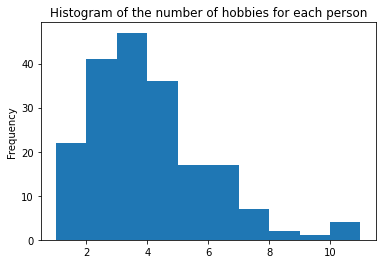

In [6]:
y.sum(axis=1).plot.hist(title='Histogram of the number of hobbies for each person')

In [16]:
x_numpy, y_numpy = x.to_numpy(), y.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=0.2, random_state=seed)
print("Number of train dataset:", len(x_train))
print("Number of test dataset:", len(x_test))

Number of train dataset: 155
Number of test dataset: 39


# Models

In [8]:
# Base Classifiers ( dict format --> (name, func) : params )
base_models = {
    ("Decision Tree", DecisionTreeClassifier) : {'min_samples_split':range(2,5) , 'min_samples_leaf':range(1,4),'min_weight_fraction_leaf':[0.0,0.5],'random_state':range(0,1)},
    ("Extra Tree", ExtraTreeClassifier) : {'min_samples_split':range(2,5) , 'min_samples_leaf':range(1,4),'min_weight_fraction_leaf':[0.0,0.5],'random_state':range(0,1)},
    ("Extra Trees", ExtraTreesClassifier) : {'n_estimators':range(90,120),'min_samples_split':range(2,5) , 'min_samples_leaf':range(1,4),'min_weight_fraction_leaf':[0.0,0.5],'random_state':range(0,1)},
    ("Random Forest", RandomForestClassifier) :{'n_estimators':range(90,120),'min_samples_split':range(2,5),'min_samples_leaf':range(1,4),'min_weight_fraction_leaf':[0.0,0.5],'random_state':range(0,1)},
    ("MLP", MLPClassifier) : {'hidden_layer_sizes': [(128,64,32),(64,32),(64)],'alpha':[1e-3, 1e-2, 1e-1, 1], 'max_iter': [2000],'random_state':range(0,1)},
    ("Ridge", RidgeClassifierCV) : {'alphas':[1e-3, 1e-2, 1e-1, 1.0,10.0]}
}

base_models_with_errors = {
    # Error: No neighbors found for test samples array (need to increase the radius size to 20, only can run)
    ("Radius Neighbours", RadiusNeighborsClassifier) : {'radius':[1.0,1.5,2.0],'leaf_size':range(20,40),'p':range(1,3)},
}

# Adaptation approaches
adapt_models = {
    ("Binary Relevance kNN A", BRkNNaClassifier) : {'k': range(1,3)},
    ("Binary Relevance kNN B", BRkNNbClassifier) : {'k': range(1,3)},
    ("Multi-Label KNN", MLkNN) : {'k': range(1,3), 's': [0.5, 0.7, 1.0]},
    ("ARAM Neural Network", MLARAM) : {'threshold':[0.05], 'vigilance':[0.95]},
    ("Twin SVM", MLTSVM) : {'c_k': [2**i for i in range(-5, 5, 2)]} # need sparse input
}

# Problem Transformation
problem_transform = {
    "Binary Relevance" : BinaryRelevance,
    "Classifier Chain" : ClassifierChain,
    # "Label Powerset" : LabelPowerset # too many output because 2^20 = 1048576
}

# Ensembles of Classifiers
emsemble_methods = {
    "Distinct Random k-labtest" : RakelD,
    "Overlapping Random k-labtest" : RakelO,
    "Label Space Partitoning" : LabelSpacePartitioningClassifier,
    "Majoity Voting" : MajorityVotingClassifier
}
# Multi-label embeddings (KIV)

# Hyperparameters

In [9]:
# Hyperparameters Tuning
num_of_kfold_splits = 5

# Training

### Adaptation approaches

In [18]:
results = {}
scoring = 'f1_micro'
y_sparse = sparse.csr_matrix(y_train)
x_sparse = sparse.csr_matrix(x_train)
for (model_name, model), params in adapt_models.items():
  kfold = KFold(n_splits=num_of_kfold_splits, random_state=None)
  clf = GridSearchCV(model(), params, cv=kfold, scoring=scoring) # n_jobs=-1, << this cause error for some reason...
  if model_name == "Twin SVM": # this model need sparse input
    clf.fit(x_sparse, y_sparse)
  else:
    clf.fit(x_train, y_train)
  results[model_name] = clf
  print(model_name,clf.best_score_)

Binary Relevance kNN A 0.36447189476856845
Binary Relevance kNN B 0.01881297455915376
Multi-Label KNN 0.36447189476856845
ARAM Neural Network 0.32419362837859056
Twin SVM 0.3467019561932747


### Problem Transformation

In [21]:
def convertToParamsForProblemTransformation(base_models):
  parameters = []
  for (model_name, model), params in base_models.items():
    parameter = {}
    parameter["classifier"] = [model()]
    for param_name, param_value in params.items():
      parameter["classifier__"+param_name] = param_value
    parameters.append(parameter)
  return parameters

parameters = convertToParamsForProblemTransformation(base_models)

In [ ]:
scoring = 'f1_micro'
x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=0.2, random_state=seed)
for strategy_name, strategy in problem_transform.items():
  kfold = KFold(n_splits=num_of_kfold_splits, random_state=None) # n_jobs=-1, << this cause error for some reason...
  clf = GridSearchCV(strategy(), parameters, cv=kfold, scoring=scoring)
  clf.fit(x_train, y_train)
  results[strategy_name] = clf
  print(strategy_name,clf.best_score_)

### Ensembles of Classifiers (Under reconstruction)

#### Adaptation approaches

In [ ]:
def convertToParamsForProblemTransformation(base_models):
  parameters = []
  for (model_name, model), params in base_models.items():
    parameter = {}
    parameter["classifier"] = model()
    for param_name, param_value in params.items():
      paramter["classifier__"+param_name] = param_value
    parameters.append(parameter)

  return paramters

In [ ]:
scoring = 'f1_micro'
for emsemble_name, emsemble_method in emsemble_methods.items():
  for strategy_name, strategy in problem_transform.items():
    for base_model_name, base_model in base_models.items():
      kfold = KFold(n_splits=num_of_kfold_splits, random_state=seed)
      model = strategy(
              classifier = base_model(),
              require_dense = [False, True] # depens on the data is sparse or dense
      )
      cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1, scoring=scoring)
      results.append(cv_results)
      names.append(model_name)
      msg = "%s: %f (%f)" % (model_name, cv_results.mean(), cv_results.std())
      print(msg)
      classifier = MajorityVotingClassifier(
    clusterer = FixedLabelSpaceClusterer(clusters = [[1,3,4], [0, 2, 5]]),
    classifier = ClassifierChain(classifier=GaussianNB())
)
classifier.fit(X_train,y_train)
predictions = classifier.predict(X_test)

In [ ]:
classifier = MajorityVotingClassifier(
    clusterer = FixedLabelSpaceClusterer(clusters = [[1,3,4], [0, 2, 5]]),
    classifier = ClassifierChain(classifier=GaussianNB())
)
classifier.fit(X_train,y_train)


# Evaluation 

In [12]:
for model_name, model in results.items():
  y_pred = model.predict(x_test)
  score = f1_score(y_test, y_pred, average='micro')
  print(model_name, score)

Binary Relevance kNN A 0.3900709219858156
Binary Relevance kNN B 0.035460992907801414
Multi-Label KNN 0.3900709219858156
ARAM Neural Network 0.37837837837837834
Twin SVM 0.37974683544303794


In [ ]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()